* dataset from https://kaggle.com/competitions/playground-series-s4e1
* This dataset was generated from a deep learning model trained on the [Bank Customer Churn Prediction dataset](https://www.kaggle.com/datasets/shantanudhakadd/bank-customer-churn-prediction). Feature distributions are close to, but not exactly the same, as the original.
* EDA code partly from https://www.kaggle.com/code/akhiljethwa/playground-s4e1-eda-modeling-xgboost

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
rc = {
    "axes.facecolor": "#F8F8F8",
    "figure.facecolor": "#F8F8F8",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7" + "30",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4,
}

sns.set(rc=rc)
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

from colorama import Style, Fore
blk = Style.BRIGHT + Fore.BLACK
mgt = Style.BRIGHT + Fore.MAGENTA
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

plt.style.use('fivethirtyeight')

## Load (training) dataset 

In [4]:
train_data = pd.read_csv('data/train.csv')
# test_data = pd.read_csv('data/test.csv')
# sample_submission = pd.read_csv('data/sample_submission.csv')

## Data Description:

- **Customer ID:** A unique identifier for each customer
- **Surname:** The customer's surname or last name
- **Credit Score:** A numerical value representing the customer's credit score
- **Geography:** The country where the customer resides
- **Gender:** The customer's gender
- **Age:** The customer's age.
- **Tenure:** The number of years the customer has been with the bank
- **Balance:** The customer's account balance
- **NumOfProducts:** The number of bank products the customer uses (e.g., savings account, credit card)
- **HasCrCard:** Whether the customer has a credit card
- **IsActiveMember:** Whether the customer is an active member
- **EstimatedSalary:** The estimated salary of the customer
- **Exited:** Whether the customer has churned (Target Variable)

In [5]:
train_data.head(10)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
5,5,15771669,Genovese,588,Germany,Male,36.0,4,131778.58,1,1.0,0.0,136024.31,1
6,6,15692819,Ch'ang,593,France,Female,30.0,8,144772.69,1,1.0,0.0,29792.11,0
7,7,15669611,Chukwuebuka,678,Spain,Male,37.0,1,138476.41,1,1.0,0.0,106851.60,0
8,8,15691707,Manna,676,France,Male,43.0,4,0.00,2,1.0,0.0,142917.13,0
9,9,15591721,Cattaneo,583,Germany,Male,40.0,4,81274.33,1,1.0,1.0,170843.07,0


In [6]:
# summary statistics
train_data.drop(columns=['CustomerId', 'id']).describe().style.background_gradient()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


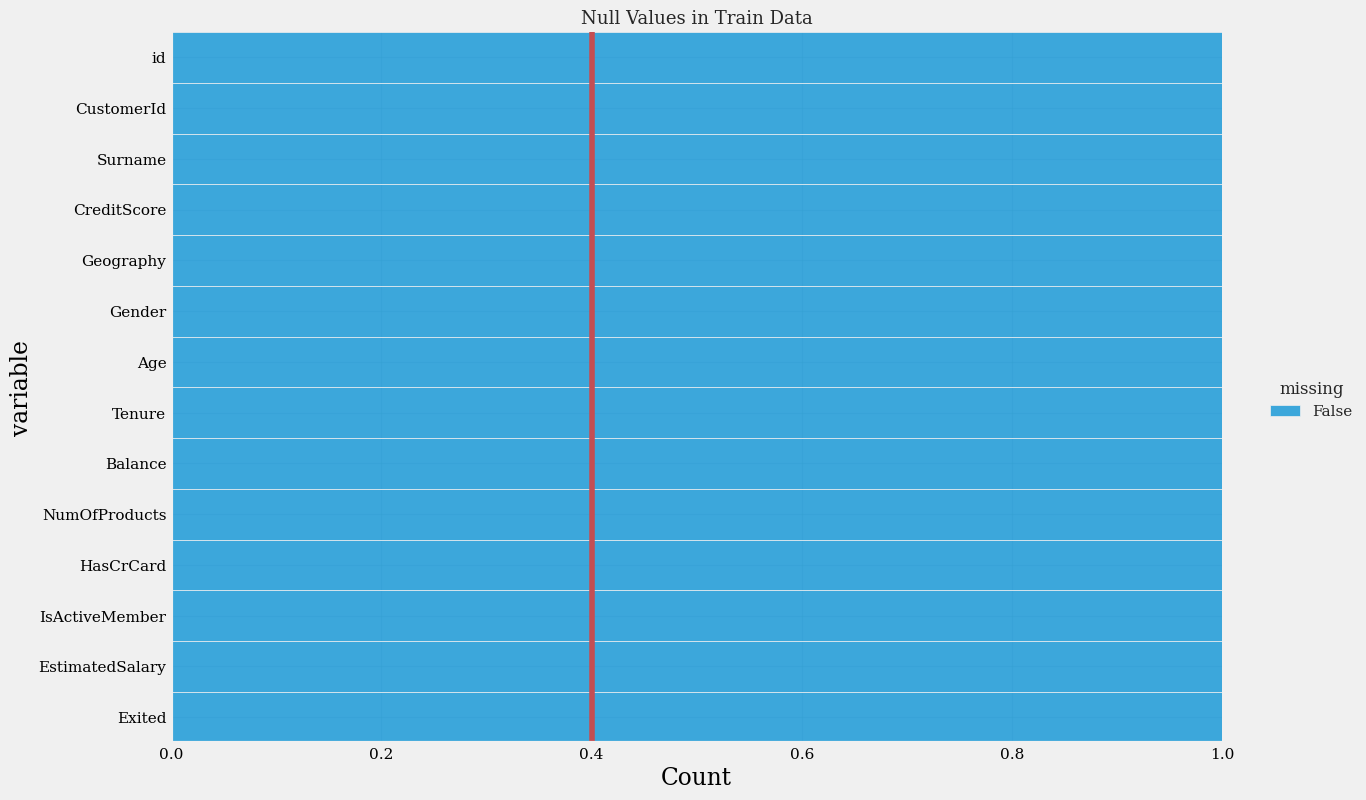

In [7]:
sns.displot(data=train_data.isnull().melt(value_name='missing'),
    y='variable',
    hue='missing',
    multiple='fill',
    height=8,
#     width=10,
    aspect=1.6
)

# specifying a threshold value
plt.axvline(0.4, color='r')
plt.title('Null Values in Train Data', fontsize=13)
plt.show()

# -------------------------

# sns.displot(data=test_data.isnull().melt(value_name='missing'),
#     y='variable',
#     hue='missing',
#     multiple='fill',
#     height=8,
# #     width=10,
#     aspect=1.6
# )

# # specifying a threshold value
# plt.axvline(0.4, color='r')
# plt.title('Null Values in Test Data', fontsize=13)
# plt.show()

## Target Variable Analysis

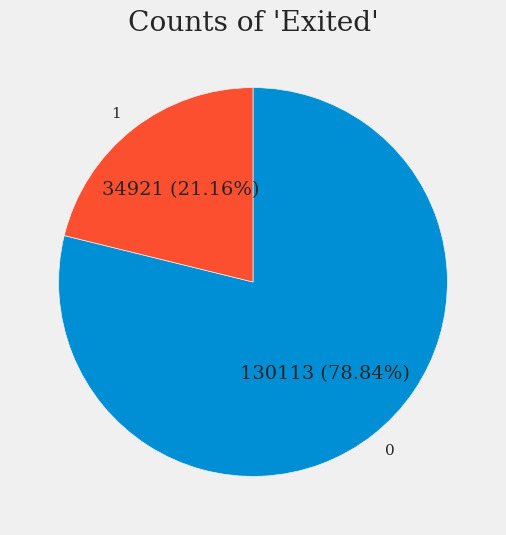

In [8]:
counts = train_data['Exited'].value_counts().sort_index()

# Define a formatting function for autopct
def func(pct, allvalues):
    absolute = int(round(pct/100.*sum(allvalues)))
    return f"{absolute} ({pct:.2f}%)"


plt.figure(figsize=(6,6))
plt.pie(
    counts,
    labels=counts.index.tolist(),
    autopct=lambda pct: func(pct, counts),
    #colors=['#66b3ff','#ff9999'],  # Optional: custom colors
    startangle=90,
    counterclock=False
)
plt.title("Counts of 'Exited'")
plt.show()


# train_data['Exited'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True, colors=['b','r'])
# # ax[0].set_title('Pie-Plot')
# ax[0].set_ylabel('')

# sns.countplot(x='Exited',data=train_data,ax=ax[1], palette=['b', 'r'])
# sns.despine()
# # ax[1].set_title('Count-Plot')
# plt.suptitle('Target Value Anaysis - Competition Data')
# plt.show()

In [9]:
# Unique value counts for each column
unique_counts = train_data.nunique()

# Threshold to distinguish continuous and categorical
threshold = 12

continuous_vars = unique_counts[unique_counts > threshold].index.tolist()
categorical_vars = unique_counts[unique_counts <= threshold].index.tolist()

# Removing the 'outcome' from categorical since it's our target variable
if 'outcome' in categorical_vars:
    categorical_vars.remove('outcome')
if 'id' in continuous_vars:
    continuous_vars.remove('id')

# print(f"Categorical Variables: {categorical_vars}")
# print(f"Continousl/Numerical Variables: {continuous_vars}")

## 2.3 Categorical Variables Analysis:    
In statistics, a categorical variable (also called qualitative variable) is a variable that can take on one of a limited, and usually fixed, number of possible values, assigning each individual or other unit of observation to a particular group or nominal category on the basis of some qualitative property. Categorical data is the statistical data type consisting of categorical variables or of data that has been converted into that form.

In our data categorical varibles are:

- Geography
- Gender
- Tenure
- NumOfProducts
- HasCrCard
- IsActiveMember

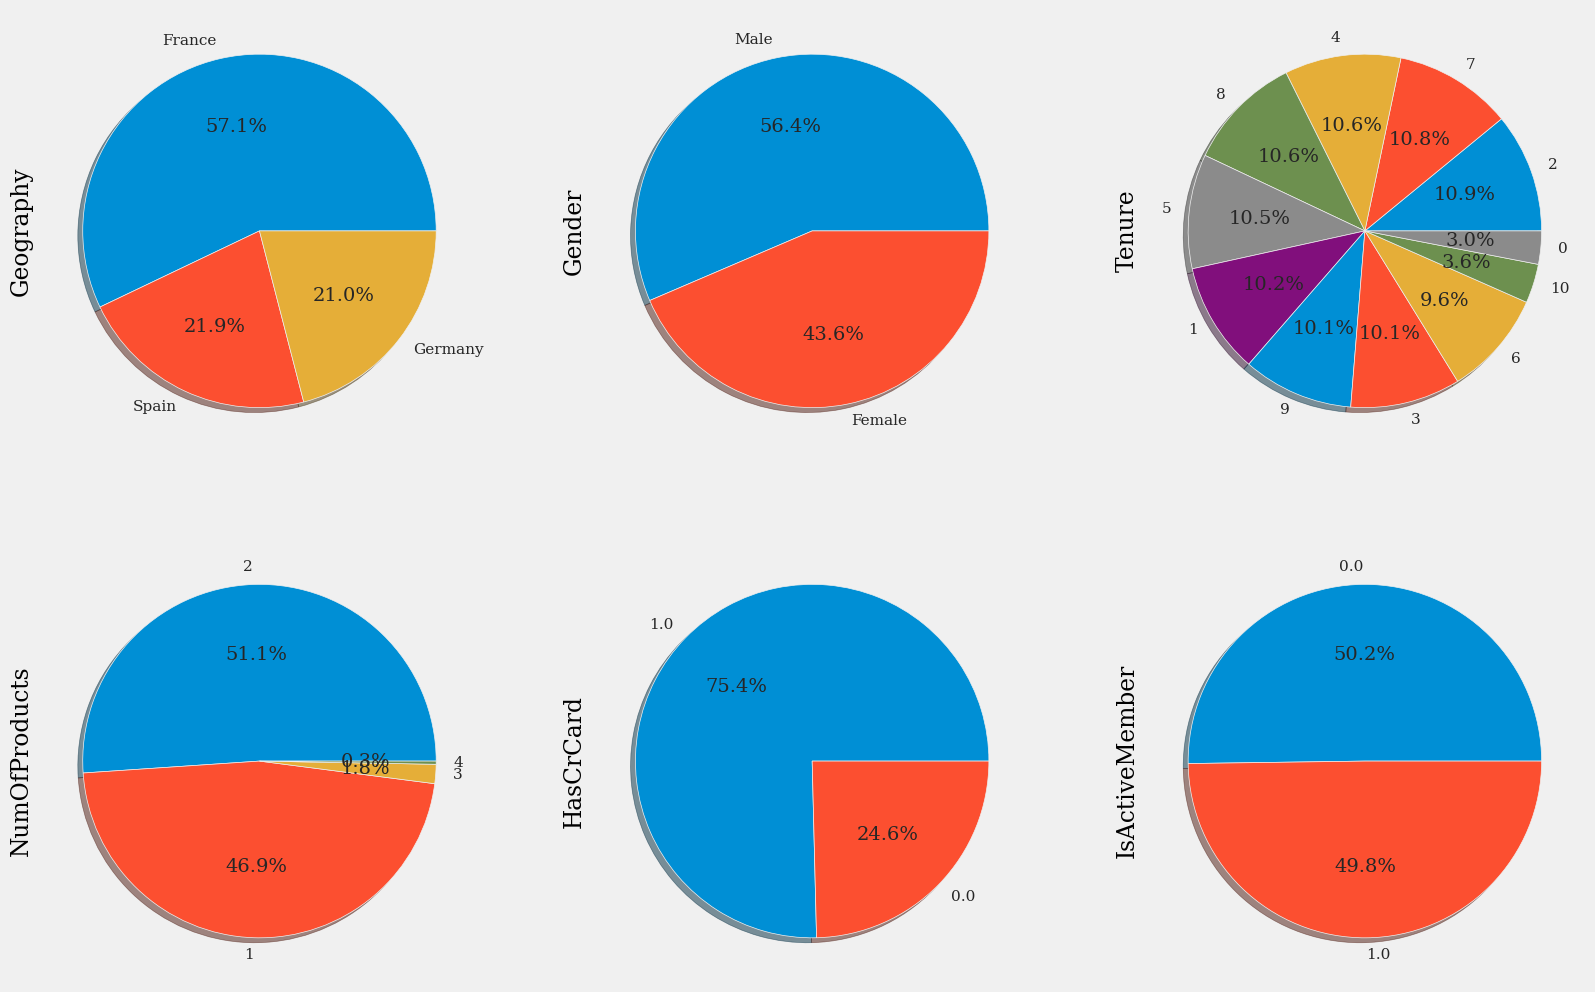

In [10]:
if 'Exited' in categorical_vars:
    categorical_vars.remove('Exited')

plt.figure(figsize=(18,12))
for i, column in enumerate(categorical_vars):    
    plt.subplot(2,3,i+1)
    train_data[column].value_counts().plot.pie(autopct='%1.1f%%', shadow=True)
    plt.ylabel(f'{column}')

- Some of the variables like `IsActiveMember`, `Tenure` and `Gender` are almost equaly distributed while the other variables like `HasCrCard`, `NumOfProducts`, and `Gender` are not equaly distributed.
- At first `Tenure` seems like continuous variable but it is a categorical variable with 11 classes from 0 to 10.

## Continuous variables are:

- CreditScore
- Age
- Balance
- EstimatedSalary

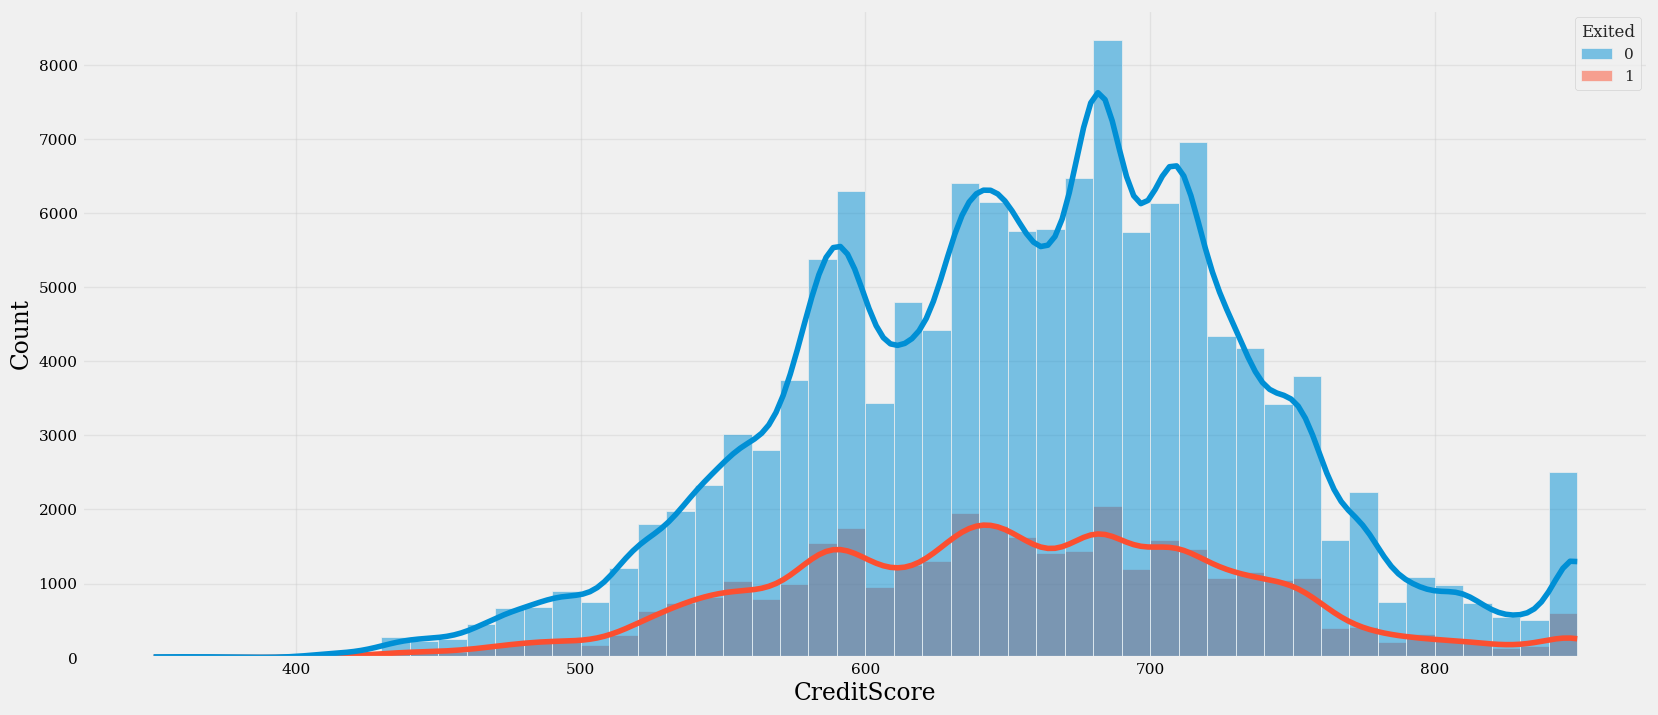

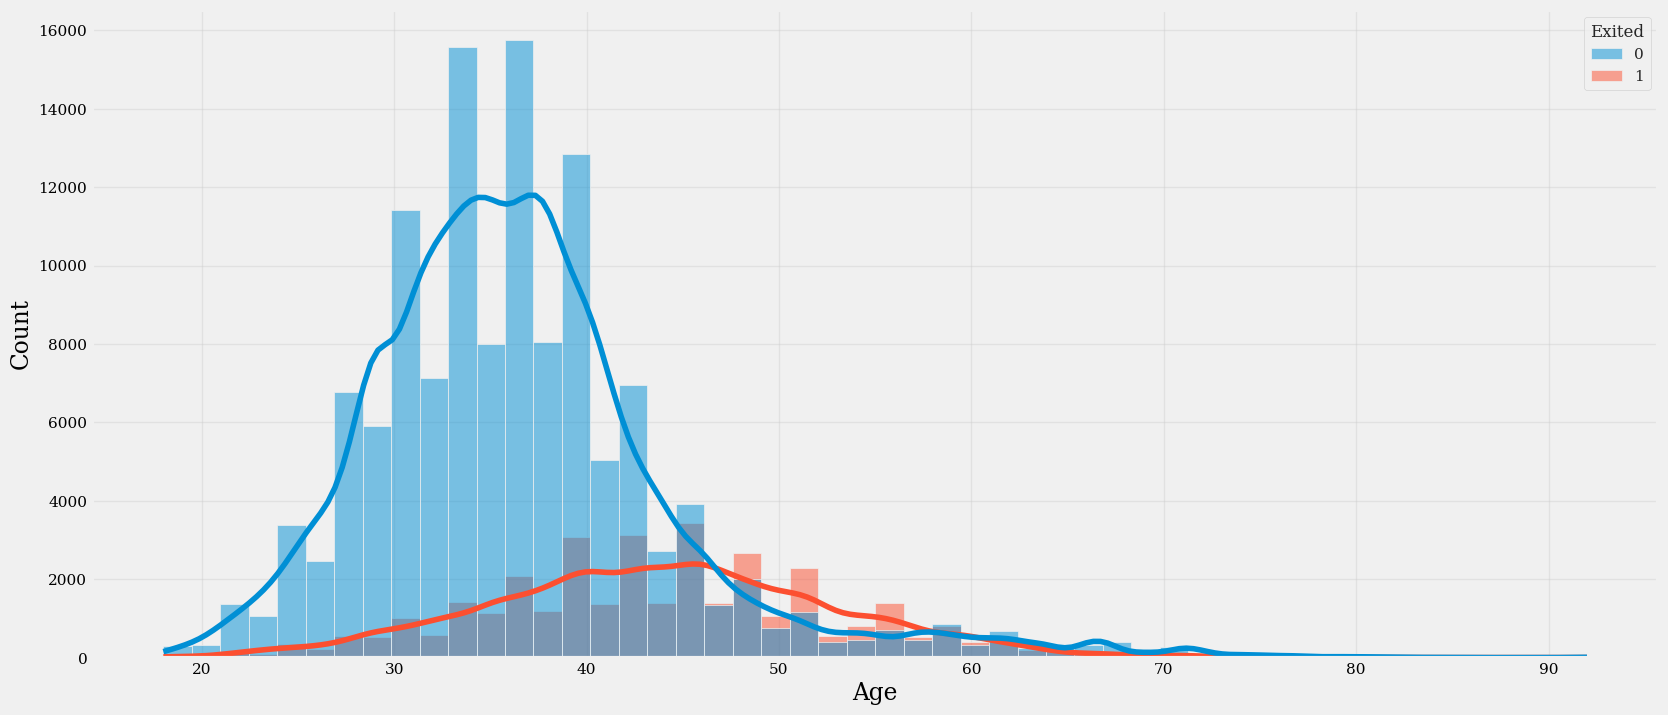

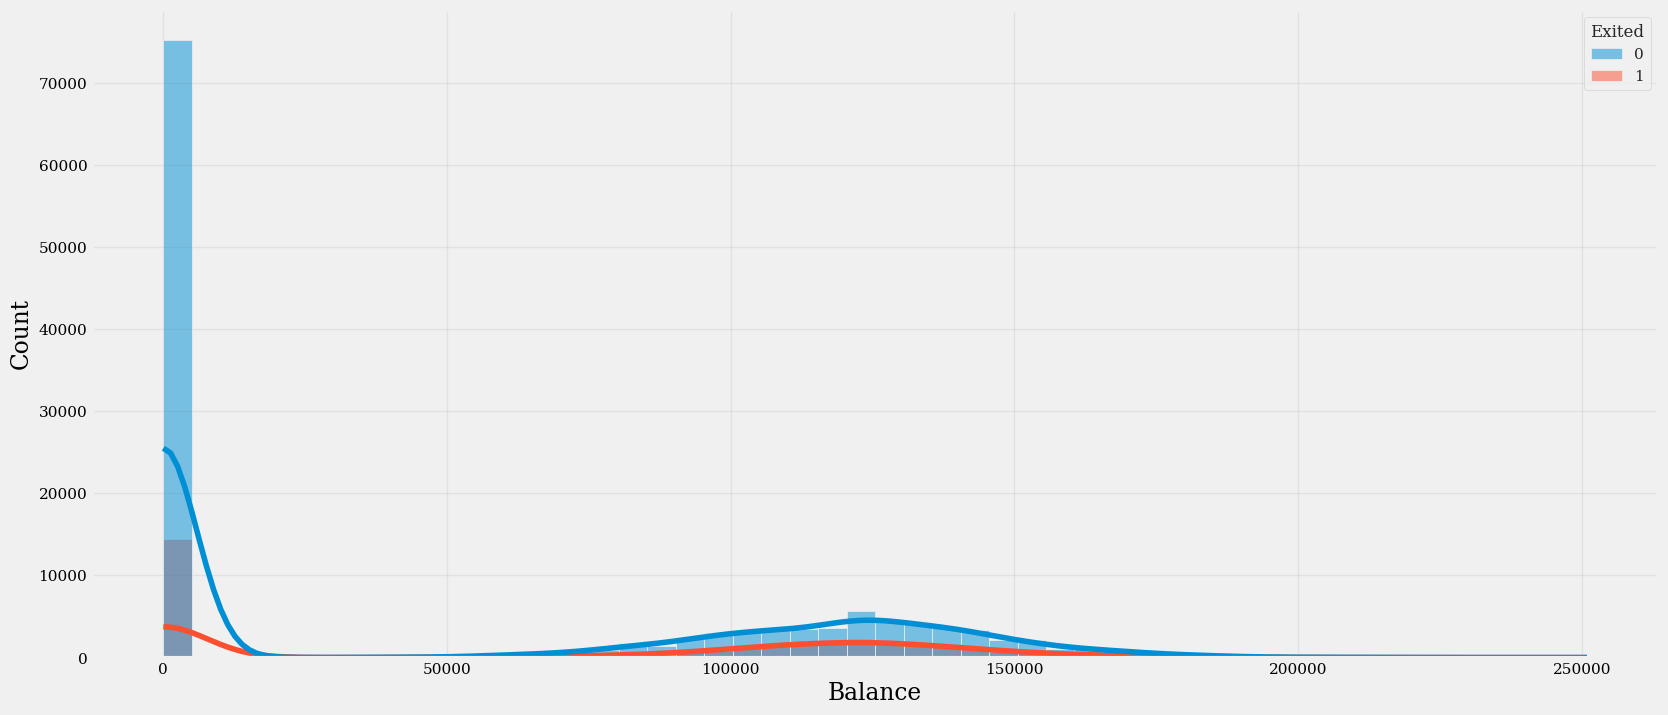

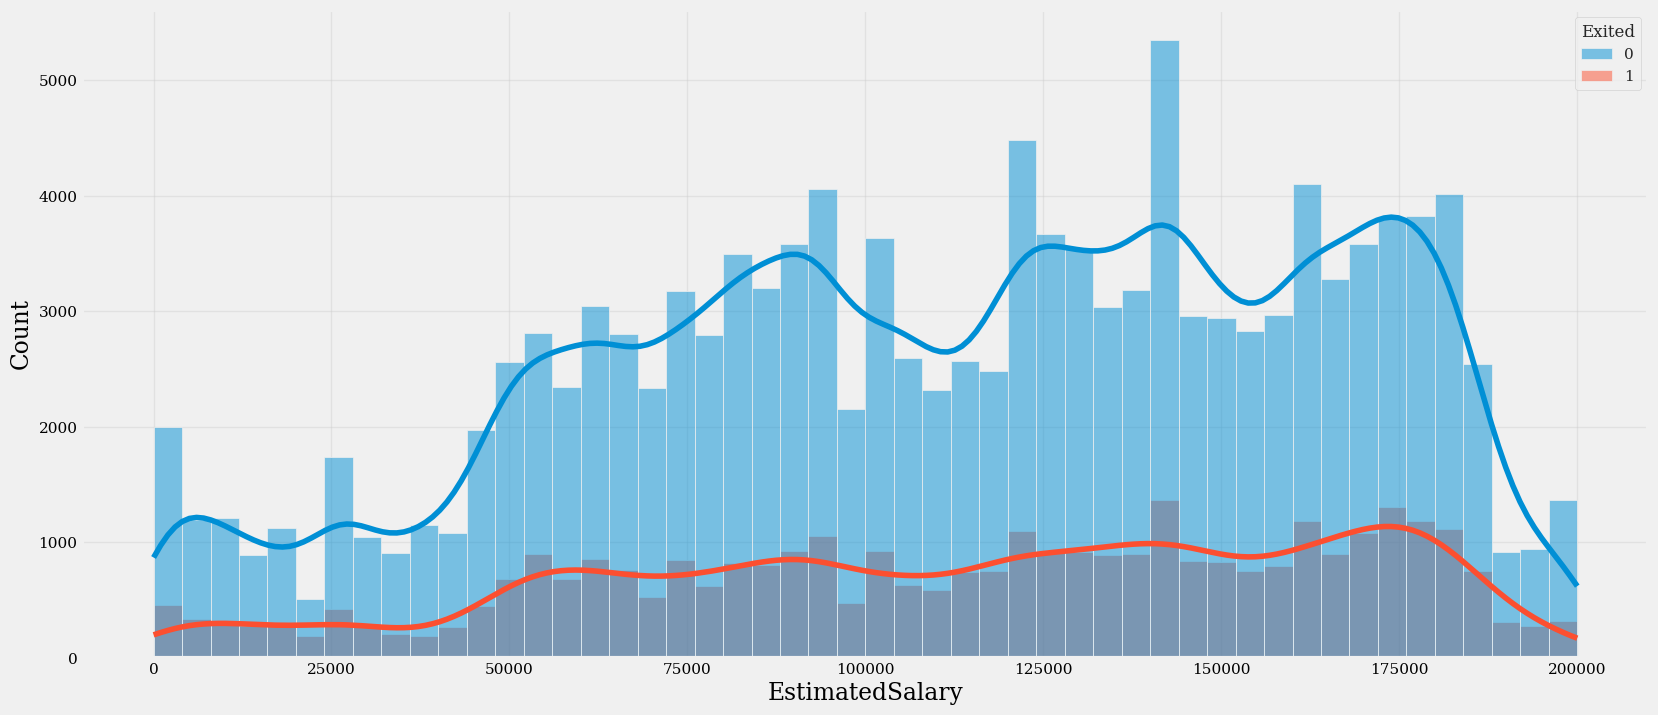

In [11]:
if 'CustomerId' in continuous_vars:
    continuous_vars.remove('CustomerId')
if 'Surname' in continuous_vars:    
    continuous_vars.remove('Surname')

for column in continuous_vars:
    fig, ax = plt.subplots(figsize=(18, 8))
    fig = sns.histplot(data=train_data, x=column, hue="Exited", bins=50, kde=True)
    plt.show()

- Majority of the data from `balance` variable is 0 only which makes the distribution skewed to 0 side.
- Other variables also show the skewness in the distributions.
- Distribution of data for both classes is almost same for all the variables.

## Multivariate Analysis:
Multivariate analysis is based in observation and analysis of more than one statistical outcome variable at a time.

In [12]:
train_data.columns

Index(['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

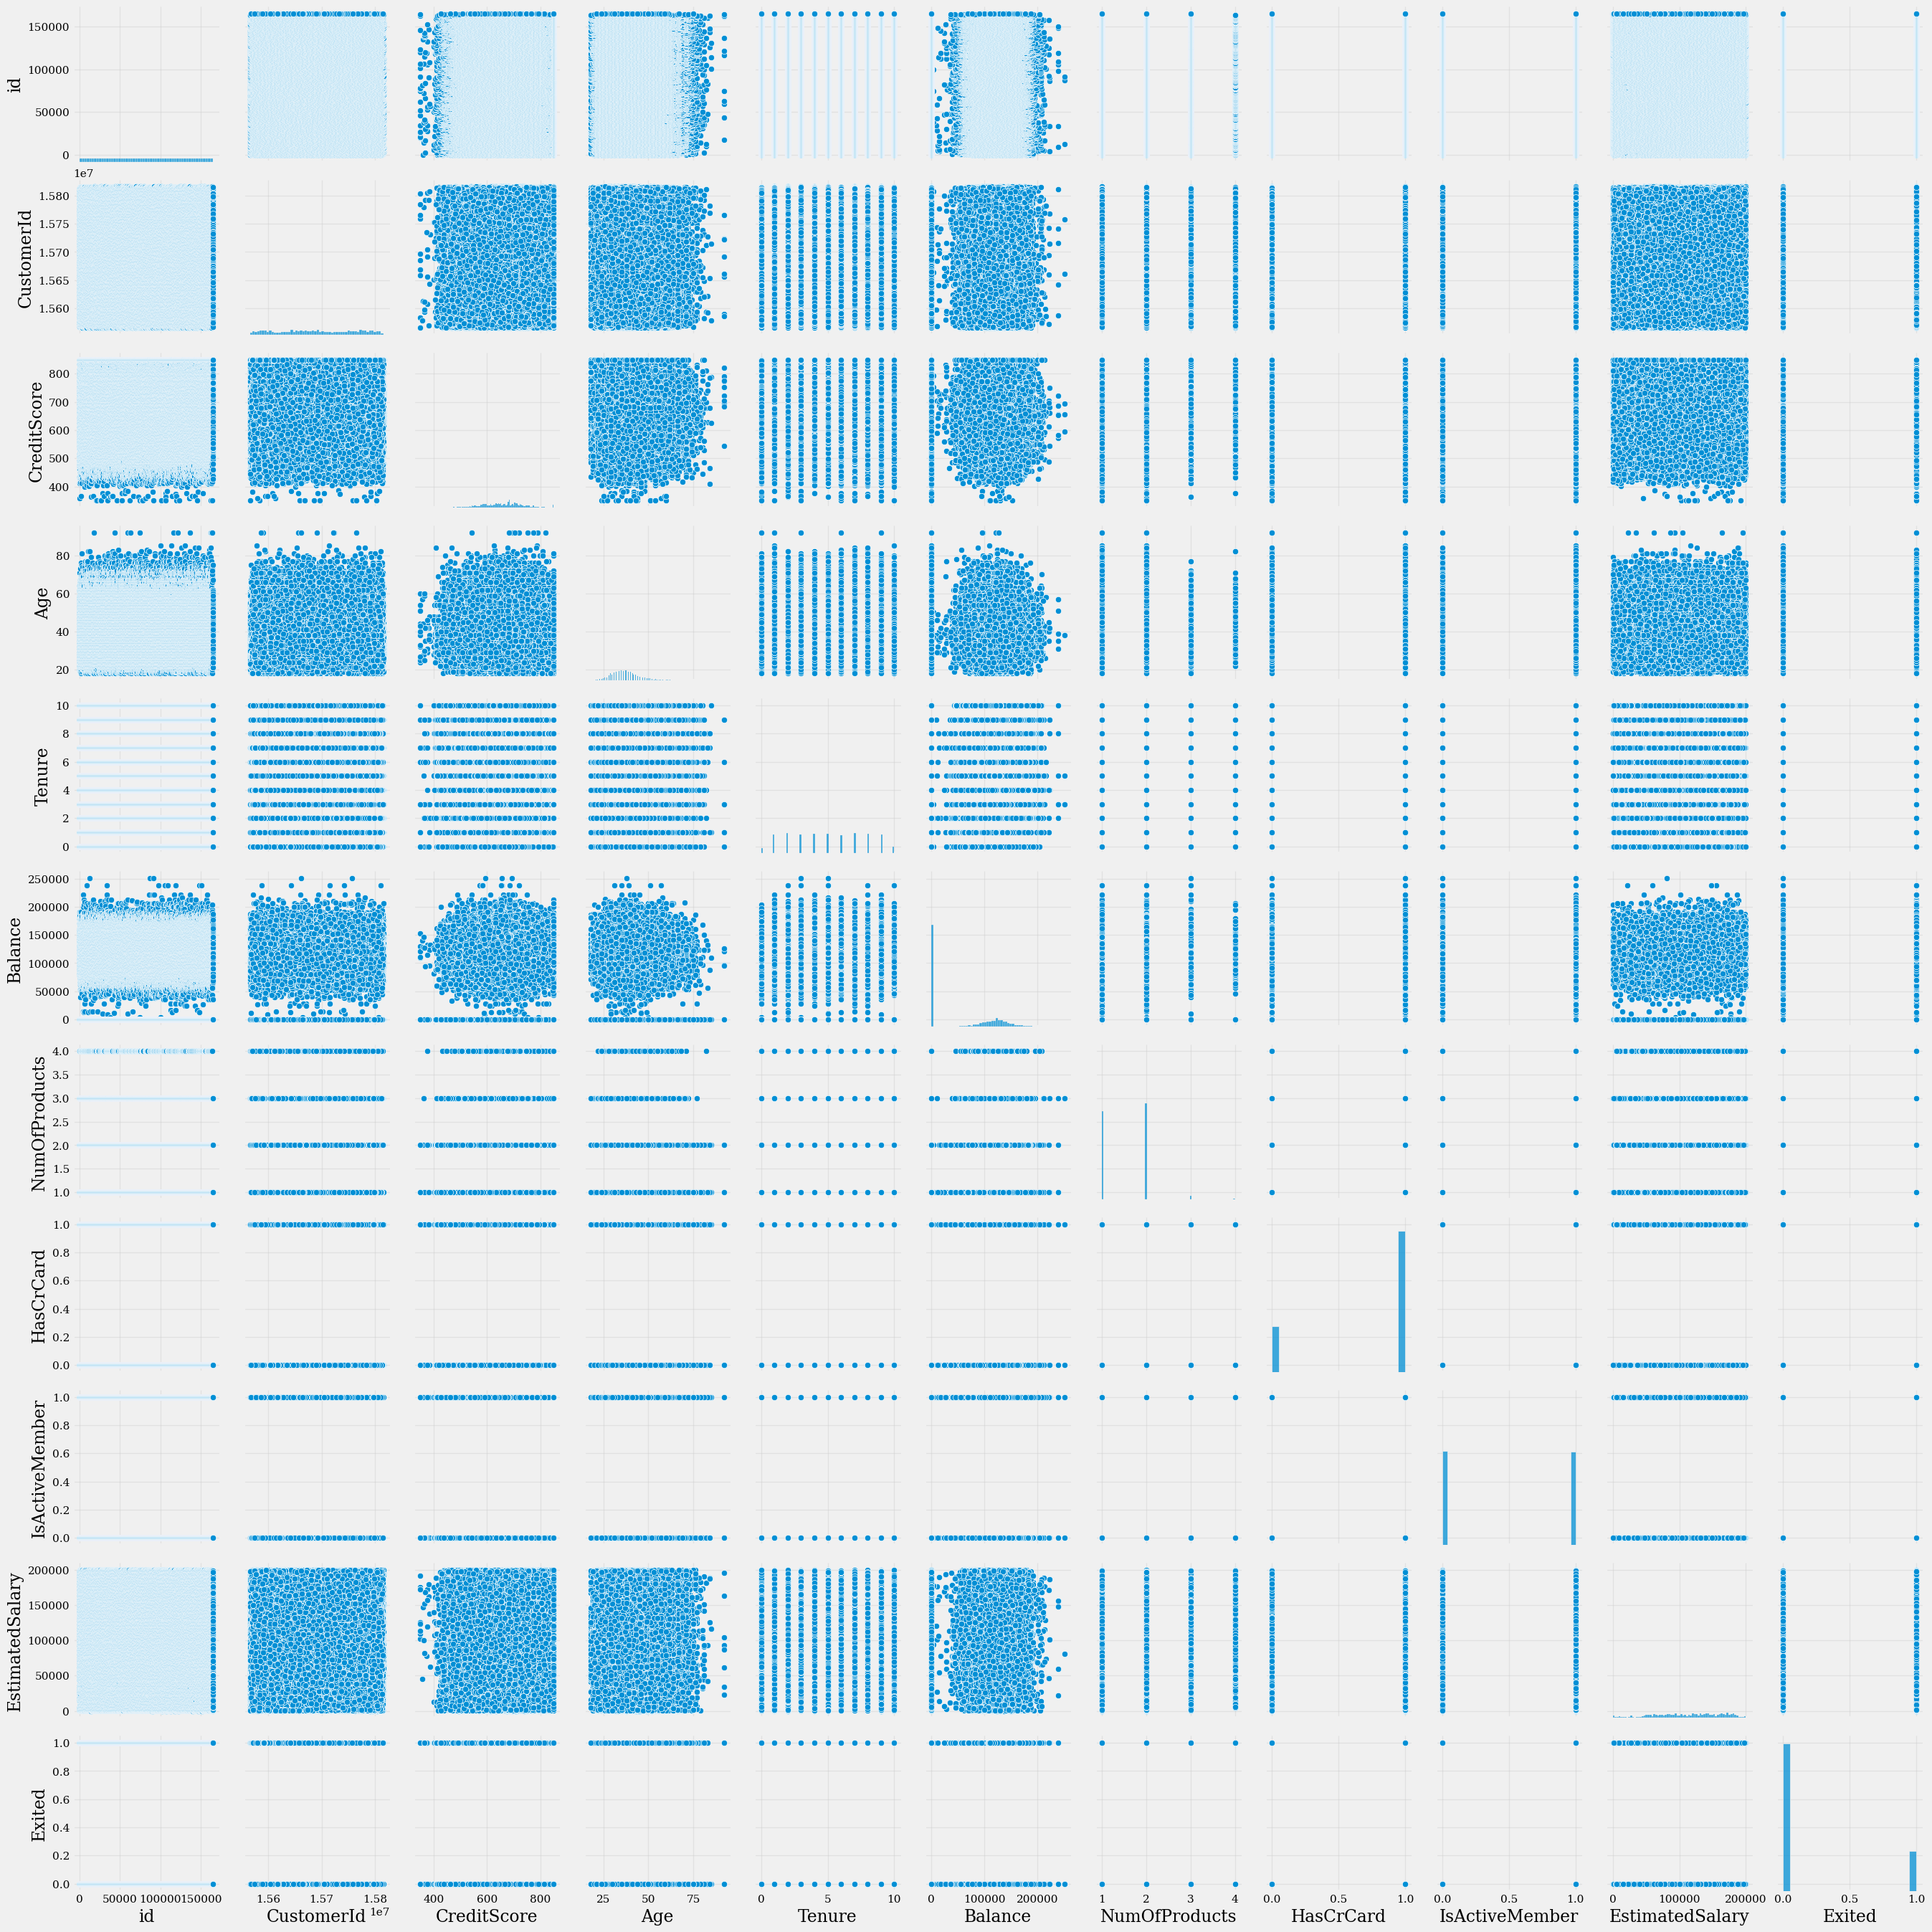

In [13]:
# pairplot for continuous variables
sns.pairplot(train_data)
# df3 = train_data[['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Exited']].copy()
# sns.pairplot(df3)
# sns.pairplot(df3, hue="Exited", corner=True)
plt.show()

## Correlation Analysis:

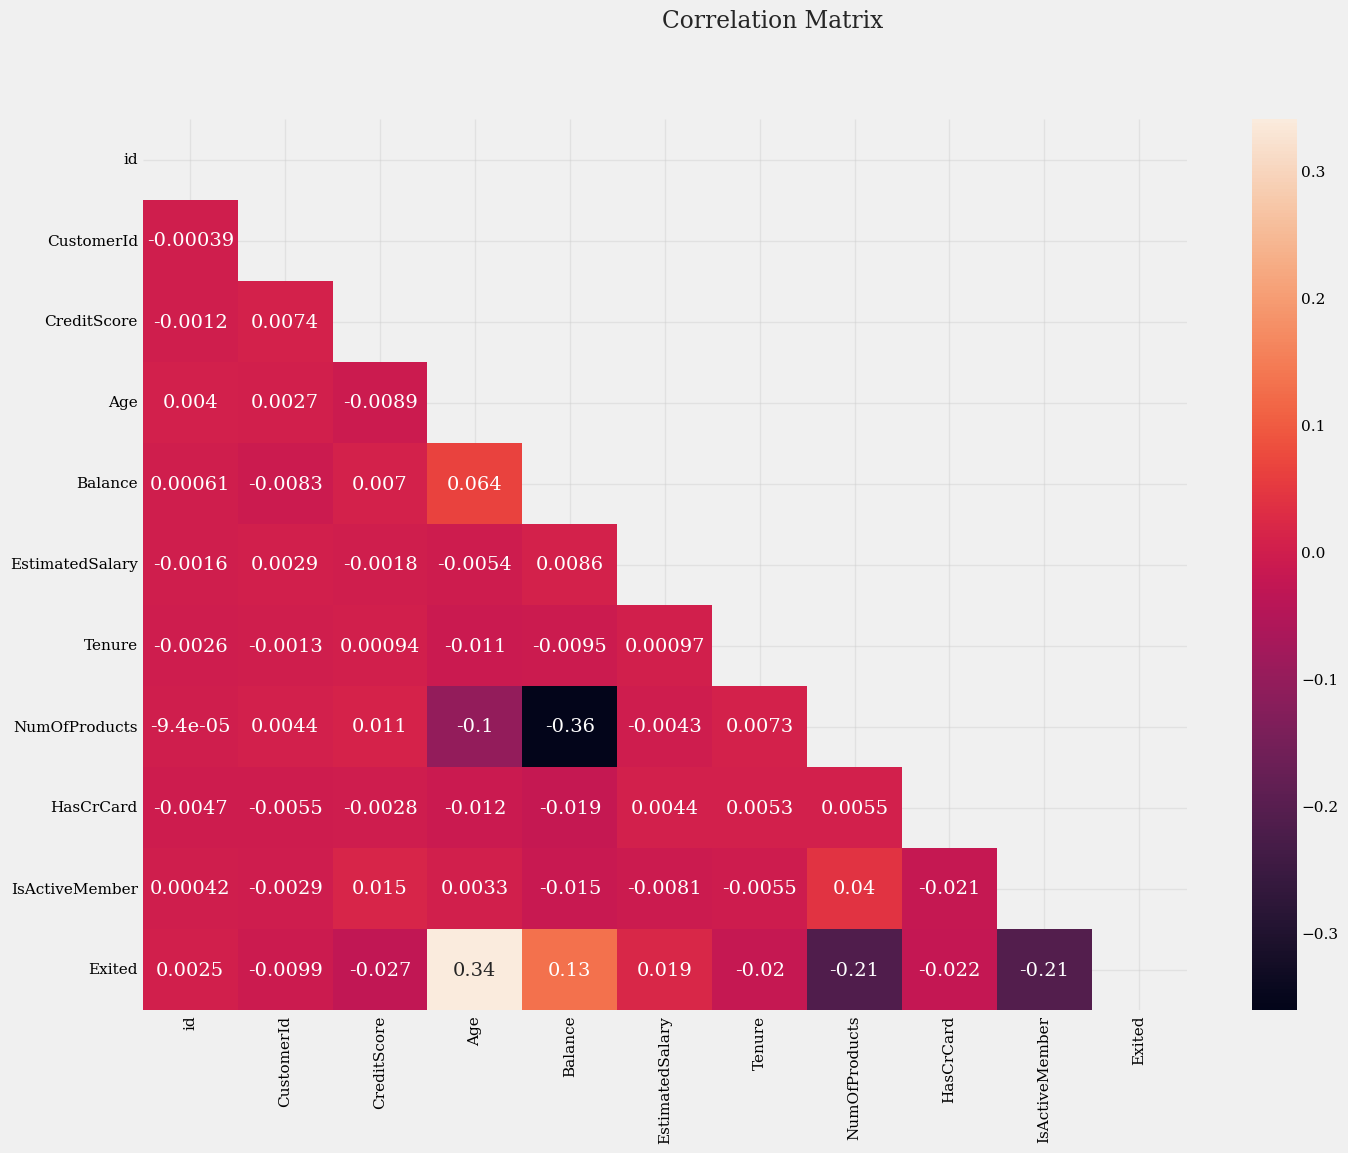

In [14]:
df4 = train_data[['id', 'CustomerId', 'CreditScore', 'Age', 'Balance', 'EstimatedSalary',
       'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited']].copy()

corr_matrix=df4.corr()

mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True

f,ax=plt.subplots(figsize=(15,11))
sns.heatmap(corr_matrix, mask=mask, annot=True)
plt.suptitle('Correlation Matrix')
plt.show()